# GP Recap and example

In [36]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
from sklearn.model_selection import train_test_split

## MVN Primer

$$p(x \mid \mu, \Sigma) = (2\pi)^{-n/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{T}\Sigma^{-1}(x-\mu) \right\}$$

JOINT: 

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

MARGINAL: 

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

CONDITIONAL: $$p(x \mid y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$



## Modeling correlation

General expectation of continuity as you move from one adjacent point to another. In the absence of significant noise, two adjacent points ought to have fairly similar $f$ values.

$$ k(x_i, x_j) = \sigma_f^2 exp( \frac{-(x_i-x_j)^2}{2l^2}) $$

$l$ is correlation length, $\sigma_f^2$ amplitude.



In [37]:
#Correlation Kernel
def exp_kernel(x1,x2, params):
    amplitude=params[0]
    scale=params[1]
    return amplitude * amplitude*np.exp(-((x1-x2)**2) / (2.0*scale))

#Covariance Matrix
covariance = lambda kernel, x1, x2, params: \
    np.array([[kernel(xi1, xi2, params) for xi1 in x1] for xi2 in x2])

Each curve in plots is generated as:

In [46]:
a = 1.0
nsamps = 100
ell=10
xx = np.linspace(0,20,nsamps)

#Create Covariance Matrix
sigma = covariance(exp_kernel,xx,xx, [a,ell]) + np.eye(nsamps)*1e-06

#Draw samples from a 0-mean gaussian with cov=sigma
samples = np.random.multivariate_normal(np.zeros(nsamps), sigma)

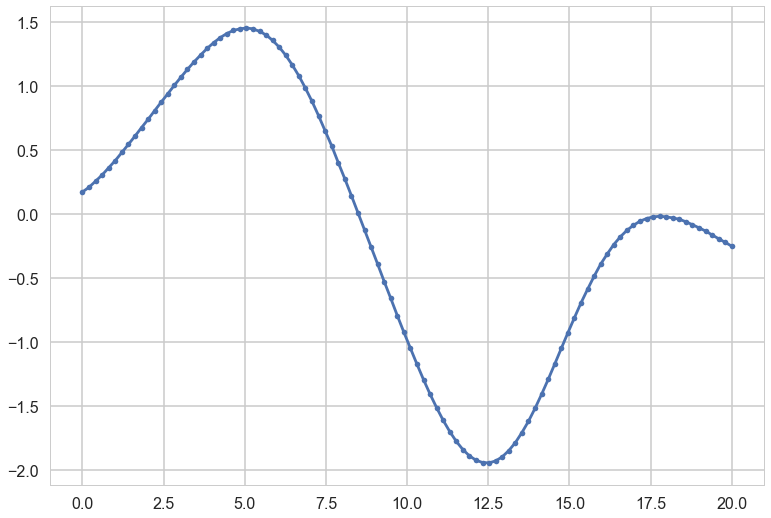

In [47]:
plt.plot(xx, samples, '.-');

The greater the correlation length, the smoother the curve.

We can consider the curve as a point in a multi-dimensional space, a draw from a multivariate gaussian with as many points as points on the curve.

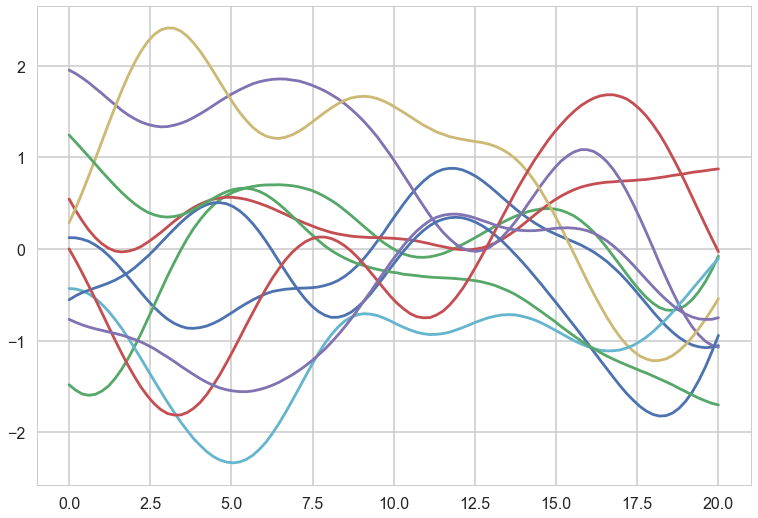

In [57]:
ell = 7.0
a = 1.0
nsamps = 100

x_star = np.linspace(0,20,nsamps)
sigma = covariance(exp_kernel,xx,xx, [a,ell]) + np.eye(nsamps)*1e-06
for i in range(10):
    samples = np.random.multivariate_normal(np.zeros(nsamps), sigma)
    plt.plot(x_star, samples)

These curves can be thought of as priors in a functional space, all corresponding to some characteristic length scale $l$, which an oracle may have told us.

## Data

Consider (say 3) data points to have been generated IID from some regression function $f(x)$ (like $w \cdot x$) with some univariate gaussian noise $\sigma^2$ at each point.

The **fundamental idea is now to pick curves from the prior which "pass through" these data points**, allowing for this $\sigma^2$ noise model

In [50]:
#"test" data
x_star = np.linspace(0,20,nsamps)

# defining the training data
x = np.array([5.0, 10.0, 15.0]) # shape 3
f = np.array([1.0, -1.0, -2.0]).reshape(-1,1)


K = covariance(exp_kernel, x,x,[a,ell])
#shape 3,3

K_star = covariance(exp_kernel,x,x_star,[a,ell])
#shape 50, 3

K_star_star = covariance(exp_kernel, x_star, x_star, [a,ell])
#shape 50,50

K_inv = np.linalg.inv(K)
#shape 3,3

mu_star = np.dot(np.dot(K_star, K_inv),f)
#shape 50

sigma_star = K_star_star  - np.dot(np.dot(K_star, K_inv),K_star.T)
#shape 50, 50


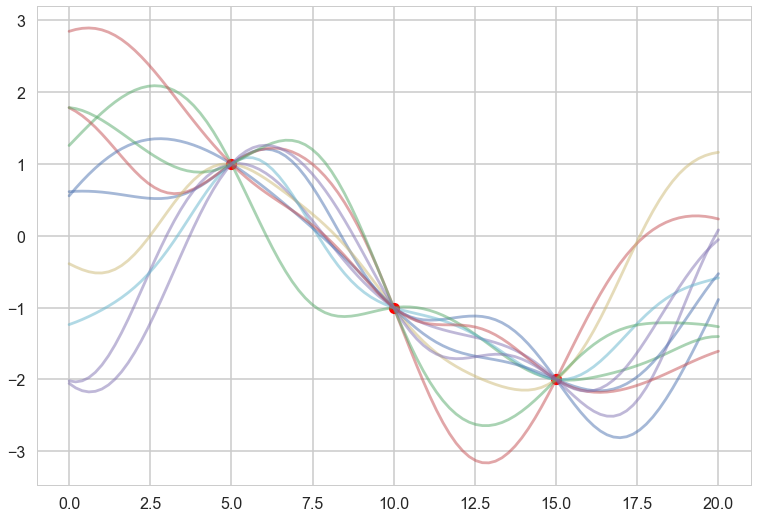

In [56]:
plt.plot(x, f, 'o', color="r");
for i in range(10):
    samples = np.random.multivariate_normal(mu_star.flatten(), sigma_star)
    plt.plot(x_star, samples, alpha=0.5)

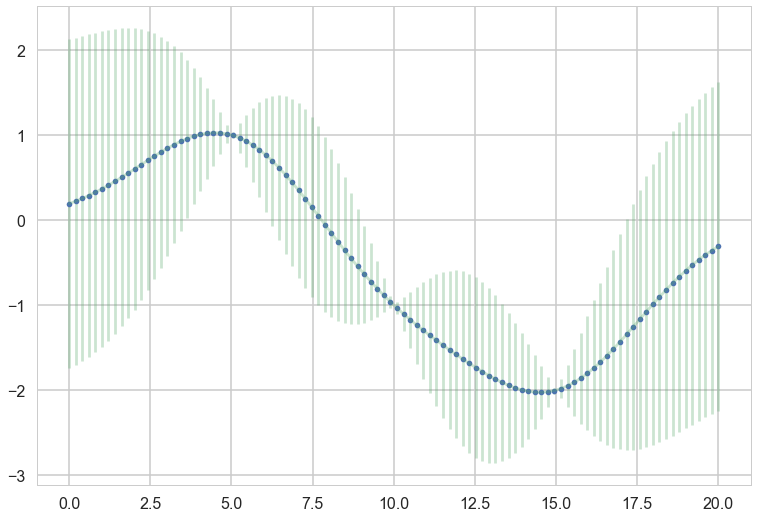

In [58]:
plt.plot(x_star, mu_star, '.')
plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);

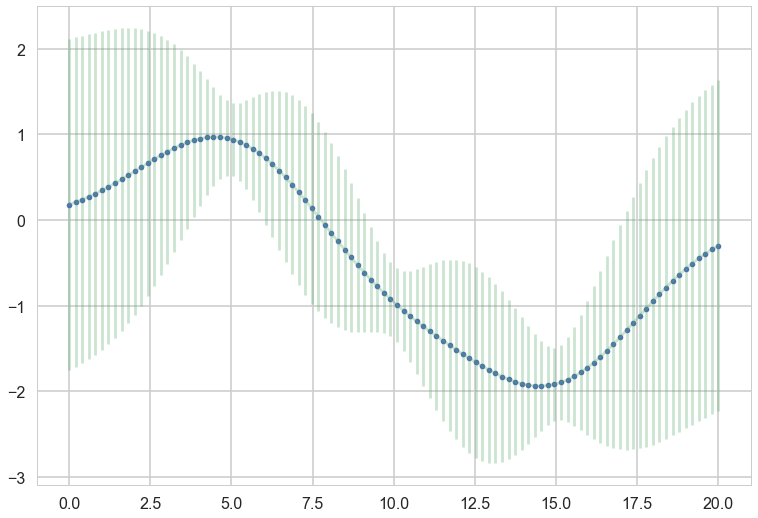

In [61]:
sigma_epsilon_sq = 0.05

K_noise = K + np.diag([sigma_epsilon_sq] * K.shape[0])
L = np.linalg.cholesky(K_noise)
#numpy.linalg.solve(a, b)
#Computes the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation ax = b.
m = np.linalg.solve(L,f)
alpha = np.linalg.solve(L.T,m)
mu_star_noise_c = np.dot(K_star, alpha)

v = np.linalg.solve(L,K_star.T)
sigma_star_noise_c = K_star_star  - np.dot(v.T,v)


plt.plot(x_star, mu_star_noise_c, '.')
plt.errorbar(x_star, mu_star_noise_c, yerr=1.96*np.sqrt(sigma_star_noise_c.diagonal()), alpha=0.3);

## The game

How did I pick specific curves from the prior?

Assume that the data and the "prior data" come from a multivariate gaussian, using the MVN formulae from above

**JOINT**:$$p(f,f^{\infty}) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_f}  \\
  {\mu_{f^{\infty}}}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_{ff}} & {\Sigma_{ff^{\infty}}}  \\
  {\Sigma_{ff^{\infty}}^T} & {\Sigma_{f^{\infty}f^{\infty}}}  \\
\end{array}
}\right]\right) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu}  \\
  {\mu_{\infty}}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  K  & {K_{\infty}}  \\
  {K_{\infty}^T} & K_{\infty\infty}  \\
\end{array}
}\right]\right)
$$

**MARGINAL**:
$$\,\,\,\,p(f) = \int p(f, f^{\infty}) df^{\infty} = \mathcal{N}(\mu_{f}, K)
$$

where: $$\,\,\,\,K = K(x, x); K_{\infty} = K(x, x^{\infty}); K_{\infty\infty} = K(x^{\infty}, x^{\infty})$$


**MARGINAL IS DECOUPLED**


>*...for the marginal of a gaussian, only the covariance of the block of the matrix involving the unmarginalized dimensions matters! Thus "if you ask only for the properties of the function (you are fitting to the data) at a finite number of points, then inference in the Gaussian process will give you the same answer if you ignore the infinitely many other points, as if you would have taken them all into account!"*
-Rasmunnsen

### Game Part 2

**Conditional**

$$p(f^{*} \mid y) = \mathcal{N}\left(\mu_{*} + K_{*}(K + \sigma^2 I)^{-1}(y-\mu), \,\,
K_{**}-K_{*}(K + \sigma^2 I)^{-1}K_{*}^T \right)
$$

**EQUALS Predictive**


## Definition of Gaussian Process

Assume we have this function vector
$ f=(f(x_1),...f(x_n))$. If, for ANY choice of input points, $(x_1,...,x_n)$, the marginal distribution over $f$:

$P(F) = \int_{f \not\in F} P(f) df$

is multi-variate Gaussian, then the distribution $P(f)$ over the function $f$ is said to be a Gaussian Process.

We write a Gaussian Process thus:

$f(x) \sim \mathcal{GP}(m(x), k(x,x\prime))$

where the mean and covariance functions can be thought of as the infinite dimensional mean vector and covariance matrix respectively.



**a Gaussian Process defines a prior distribution over functions!**

Once we have seen some data, this prior can be converted to a posterior over functions, thus restricting the set of functions that we can use based on the data.

Since the size of the "other" block of the matrix does not matter, we can do inference from a finite set of points.

Any $m$ observations in an arbitrary data set, $y = {y_1,...,y_n=m}$ can always be represented as a single point sampled from some $m$-variate Gaussian distribution. Thus, we can work backwards to 'partner' a GP with a data set, by marginalizing over the infinitely-many variables that we are not interested in, or have not observed.

### GP regression

Using a Gaussian process as a prior for our model, and a Gaussian as our data likelihood, then we can construct a Gaussian process posterior.

Likelihood: $$y|f(x),x \sim \mathcal{N}(f(x), \sigma^2I) $$

where the infinite $f(x)$ takes the place of the parameters.

Prior:  $f(x) \sim \mathcal{GP}(m(x)=0, k(x,x\prime))$

Infinite normal posterior process: $f(x)|y \sim \mathcal{GP}(m_{post}, \kappa_{post}(x,x\prime)).$



The posterior distribution for f  is:

$$\begin{aligned}
m_{post} &= k(x\prime,x)[k(x,x) + \sigma^2I]^{-1}y \\
k_{post}(x,x\prime) &= k(x\prime,x\prime) - k(x\prime, x)[k(x,x) + \sigma^2I]^{-1}k(x,x\prime)
\end{aligned}$$

Posterior predictive distribution for $f(x_*)$ for a test vector input $x_*$, given a training set X with values y for the GP is:

$$\begin{aligned}
m_* &= k(x_*,X)[k(X^T,X) + \sigma^2I]^{-1}y \\
k_* &= k(x_*,x_*) - k(x_*,X^T)[k(X^T,X) + \sigma^2I]^{-1}k(X^T,x_*)
\end{aligned}$$

The predictive distribution of test targets y∗ : add $\sigma^2 I$ to$k_*$$.

---

## Why does it work?

**Infinite basis sets and Mercer's theorem**

Now consider an infinite set of $$\phi(x)$$. Like a fourier series or a Bessel series.

We can construct an infinitely parametric model.

This is called a non-parametric model.

We just need to be able to define a finite kernel $$\kappa(x,x') = \psi(x)^T \psi(x')$$!!

## Levels of Bayes

![inline](images/bayeslevels2.png)

We shall here only show full bayes using the likelihood marginalized in function space.

## Sockeye Salmon example

Munch, Kottas and Mangel (Bayesian nonparametric analysis of stock- recruitment relationships. Canadian Journal o
f Fisheries and Aquatic Sciences, 62:1808–1821, 2005.) use Gaussian process priors to infer stock-recruitment (SR
) functions for various fish. We concentrate here on Sockeye Salmon. SR functions relate the size of a fish stock
 to the number or biomass of recruits to the fishery each year.  The authors argue that GP priors make sense to use since model uncertainty is high in Stock Recruitment theory.



In [11]:
!cat data/salmon.txt

year recruits spawners
1 68 56
2 77 62
3 299 445
4 220 279
5 142 138
6 287 428
7 276 319
8 115 102
9 64 51
10 206 289
11 222 351
12 205 282
13 233 310
14 228 266
15 188 256
16 132 144
17 285 447
18 188 186
19 224 389
20 121 113
21 311 412
22 166 176
23 248 313
24 161 162
25 226 368
26 67 54
27 201 214
28 267 429
29 121 115
30 301 407
31 244 265
32 222 301
33 195 234
34 203 229
35 210 270
36 275 478
37 286 419
38 275 490 
39 304 430
40 214 235


In [12]:
df = pd.read_csv("data/salmon.txt", sep="\s+")
df.head()

,year,recruits,spawners
0,1,68,56
1,2,77,62
2,3,299,445
3,4,220,279
4,5,142,138


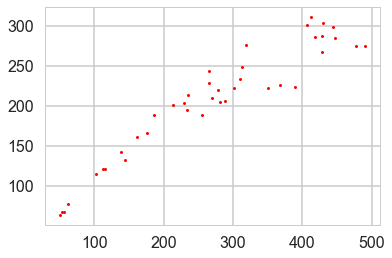

In [13]:
plt.plot(df.spawners, df.recruits, 'r.', markersize=6, label=u'Observations');

## Inference

Use the marginal likelihood:

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

The Marginal likelihood given a GP prior and a gaussian likelihood is:

$$\log p(y|X) = - \frac{n}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

In [26]:
#taken from fonnesbeck
with pm.Model() as model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 1)
    η = pm.HalfCauchy('η', 1)
    
    M = pm.gp.mean.Linear(coeffs=(df.recruits.values/df.spawners.values).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 1)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=df.spawners.values.reshape(-1,1), 
                           y=df.recruits.values, noise=σ)
    

In [27]:
with model:
    salmon_trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, η_log__, ρ_log__]
100%|██████████| 10500/10500 [02:49<00:00, 61.95it/s]
The number of effective samples is smaller than 25% for some parameters.


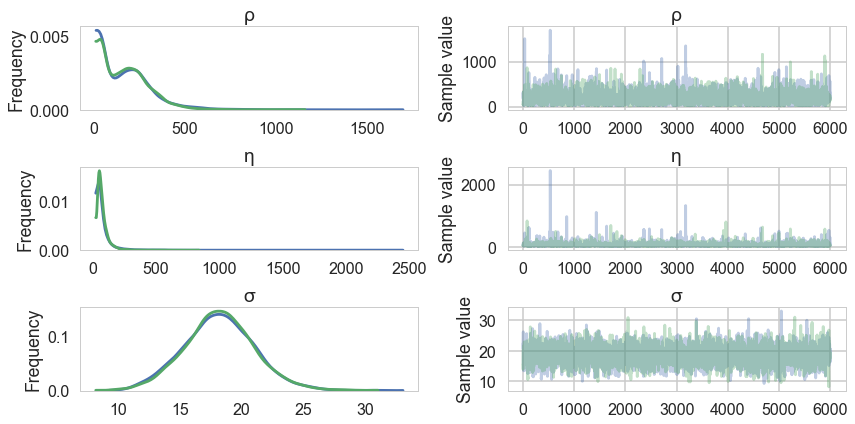

In [28]:
salmon_trace = salmon_trace[4000:]
pm.traceplot(salmon_trace, varnames=['ρ', 'η', 'σ']);

In [34]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with model:
    salmon_pred = recruit_gp.conditional("salmon_pred2", X_pred)
    salmon_samples = pm.sample_ppc(salmon_trace, vars=[salmon_pred], samples=20)

100%|██████████| 20/20 [00:00<00:00, 26.23it/s]


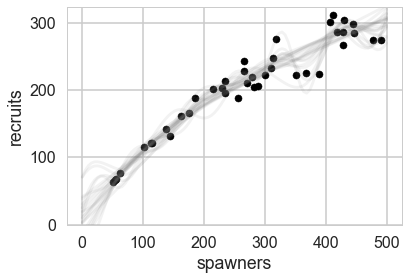

In [35]:
ax = df.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in salmon_samples['salmon_pred2']:
    ax.plot(X_pred, x, "gray", alpha=0.1);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution (via `conditional`) that covers this range of spawners.

In [31]:
# Write answer here